In [181]:
import numpy as np
import pickle  # 用 pickle 替代 cPickle
import gym
np.bool8 = np.bool_

In [182]:
import gym

In [183]:
env = gym.make("Pong-v4")
observation, _ = env.reset()

In [184]:
def show_img(observation):
    import numpy as np
    import matplotlib.pyplot as plt

    # 创建一个随机的 (210, 160, 3) 矩阵
    image = observation
    # image = prepro_1(observation)

    # 使用 matplotlib 显示图像
    plt.imshow(image)
    # plt.axis('off')  # 隐藏坐标轴
    plt.show()

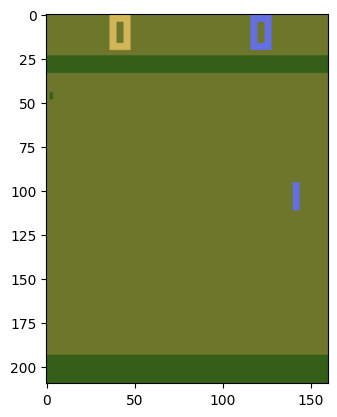

In [185]:
show_img(observation)

In [186]:
def prepro(I):
    """将 210x160x3 uint8 帧预处理为 6400 (80x80) 1D float 向量"""
    I = I[35:195]  # 裁剪
    I = I[::2, ::2, 0]  # 下采样因子为 2
    I[I == 144] = 0  # 删除背景类型 1
    I[I == 109] = 0  # 删除背景类型 2
    I[I != 0] = 1  # 其他设置为 1
    return I.astype(np.float32).ravel()

In [243]:
D = 6400
H = 200

In [260]:
from torch import nn

In [330]:
class MLP(nn.Module):
    
    
    def __init__(self, input_dim,output_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim,200,bias=False)
        self.linear2 = nn.Linear(200,output_dim,bias=False)
        
       # Xavier 初始化 + 偏置归零
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.xavier_normal_(self.linear2.weight)

        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return self.sigmoid(x)
    
    def sample_action(self,x):
        with torch.no_grad():
            prob = self.forward(x)
#             prob = torch.clamp(prob, min=1e-8, max=1-1e-8)  # 关键修复

#             m = Bernoulli(prob)
#             action = m.sample().item()  # 1 表示向上，0 表示向下
#             return int(action) + 2
        action = 2 if prob.item() < np.random.uniform() else 3
        return action

In [331]:
def discount_rewards(rewards):
    ans = np.zeros_like(rewards)
    adding = 0
    for t in reversed(range(len(rewards))):
        if rewards[t] != 0:
            adding = 0
        adding = adding * 0.99 + rewards[t]
        ans[t] = adding
    return ans

In [332]:
model = MLP(D,1)

In [333]:
from torch.optim import RMSprop
import torch

In [334]:
optimizer = RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-5)

In [ ]:
from torch.distributions import Bernoulli

observation, _ = env.reset()
episode_number = 0
prev_x = None
xs = []
logps = []
hs = []
ys = []
rewards = []
train_time = 0
total_sum = 0
while True:
    current_x = prepro(observation)
    gap = np.zeros_like(current_x) if prev_x is None else current_x - prev_x
#     h,p = policy_forward(gap)
    action = model.sample_action(torch.from_numpy(gap))
#     print(action)
    y = 0.0 if action == 2 else 1.0
    observation, reward, terminated, truncated, info = env.step(action)  # 更新为新的返回值
    prev_x = current_x
    rewards.append(reward)
    xs.append(gap)
    ys.append(y)
    total_sum += reward
    
    if terminated or truncated:
        episode_number += 1
        xs = np.vstack(xs)
        ys = np.vstack(ys).ravel()
        rewards = np.vstack(rewards).ravel()
        rewards = discount_rewards(rewards)
        rewards -= rewards.mean()
        rewards /= (rewards.std()+ EPS)

        rewards = torch.FloatTensor(rewards)
        xs = torch.FloatTensor(xs)
        ys = torch.FloatTensor(ys)
        
        ps = model(xs)
        ps = model(xs).squeeze()
#         print(ps.shape,ys.shape)

        # 防止概率为0或1导致log计算爆炸
        logps = torch.log(ys * ps + (1.0-ys) *(1.0-ps))
#         print(logps)
        loss = -(logps * rewards).mean()
#         print('loss',loss,len(rewards),sum(rewards),sum(logps))
        
        #### 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        
        print('total',total_sum)
        
        xs = []
        rewards = []
        logps = []
        hs = []
        ys = []
        prev_x = None
        total_sum = 0
        observation, _ = env.reset()
        
        

total -1.0
total -6.0
total -2.0
total -8.0
total -4.0
total -6.0
total -3.0
total -9.0
total 5.0
total 3.0
total -7.0
total -6.0
total -11.0
total -9.0
total -9.0
total -13.0
total -11.0
total -12.0
total 7.0
total -11.0
total 6.0
total -7.0
total -3.0
total -10.0
total 8.0
total -9.0
total -2.0
total -1.0
total -5.0
total 10.0
total -7.0
total -3.0
total -7.0
total -3.0
total -10.0
total -9.0
total -13.0
total -9.0
total -5.0
total -9.0
total -4.0
total -9.0
total 13.0
total -11.0
total 4.0
total -9.0
total -3.0
total 3.0
total -10.0
total -6.0
total -6.0
total -11.0
total -7.0
total -15.0
total -3.0
total 8.0
total -16.0
total 5.0
total 5.0
total -3.0
total -5.0
total -10.0
total 3.0
total 1.0
total 1.0
total -9.0
total -15.0
total -3.0
total 8.0
total -10.0
total -5.0
total 7.0
total 3.0
total -8.0
total -4.0
total -1.0
total -7.0
total -8.0
total -2.0
total -9.0
total -5.0
total -7.0
total -5.0
total -7.0
total -9.0
total -7.0
total 1.0
total -7.0
total -15.0
total -10.0
total -6.

total 9.0
total 4.0
total 4.0
total 5.0
total -6.0
total 6.0
total 5.0
total 4.0
total 5.0
total 2.0
total -13.0
total 9.0
total 11.0
total -5.0
total 1.0
total 1.0
total -1.0
total 3.0
total -9.0
total -2.0
total 6.0
total -2.0
total 10.0
total 5.0
total -1.0
total -3.0
total 6.0
total -2.0
total -6.0
total 1.0
total 11.0
total 8.0
total 8.0
total 2.0
total 8.0
total -3.0
total 9.0
total 4.0
total 4.0
total 5.0
total 10.0
total 5.0
total -4.0
total 2.0
total -2.0
total 10.0
total 11.0
total 7.0
total 7.0
total 7.0
total -4.0
total -3.0
total -9.0
total 5.0
total -11.0
total -10.0
total 4.0
total 6.0
total -7.0
total -5.0
total -9.0
total 3.0
total -3.0
total 1.0
total -12.0
total -2.0
total -13.0
total -7.0
total 3.0
total 4.0
total -8.0
total 6.0
total -3.0
total 1.0
total -4.0
total 1.0
total 8.0
total 7.0
total -5.0
total 9.0
total 1.0
total -4.0
total -9.0
total 2.0
total -3.0
total 2.0
total 4.0
total 8.0
total -9.0
total -6.0
total -7.0
total -11.0
total 9.0
total 5.0
total 2.0


In [ ]:
for k in model.parameters():
    print(k)